# Проект 'Промышленность'

## Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Исследовательский анализ данных

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

### Данные об электродах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


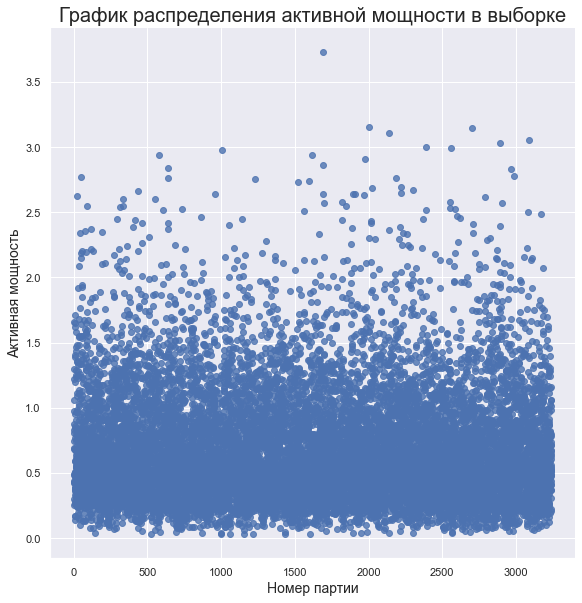

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

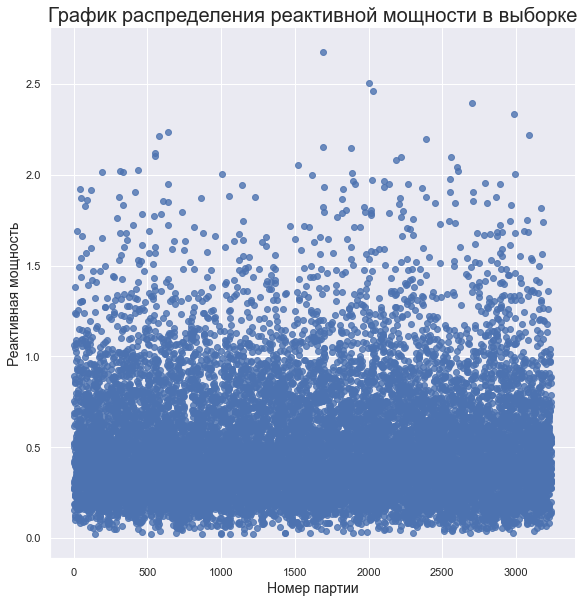

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

count    14875.000000
mean         0.500723
std          0.310880
min          0.020806
25%          0.291003
50%          0.415984
75%          0.637403
max          2.676388
Name: Реактивная мощность, dtype: float64

In [2]:
data_arc = pd.read_csv(r'C:\Users\katko\OneDrive\Desktop\data_arc.csv')
data_arc.info()
display(data_arc.head(3))

sns.set()
sns.lmplot(x='key', y='Активная мощность', data=data_arc, height=8, fit_reg = False)
plt.title('График распределения активной мощности в выборке', fontsize=20)
plt.ylabel('Активная мощность', fontsize=14)
plt.xlabel('Номер партии', fontsize=14)
plt.show()

display(data_arc['Активная мощность'].describe())


sns.lmplot(x='key', y='Реактивная мощность', data=data_arc[data_arc['Реактивная мощность'] > 0], height=8, fit_reg = False)
plt.title('График распределения реактивной мощности в выборке', fontsize=20)
plt.ylabel('Реактивная мощность', fontsize=14)
plt.xlabel('Номер партии', fontsize=14)
plt.show()

display(data_arc['Реактивная мощность'].describe())
display(data_arc[data_arc['Реактивная мощность'] >= 0]['Реактивная мощность'].describe())




In [3]:
data_arc['Начало нагрева дугой'][::14875]

0        2019-05-03 11:02:14
14875    2019-09-01 04:34:47
Name: Начало нагрева дугой, dtype: object

In [4]:
data_arc['Конец нагрева дугой'][::14875]

0        2019-05-03 11:06:02
14875    2019-09-01 04:36:08
Name: Конец нагрева дугой, dtype: object

In [5]:
print(f'Значения "Номер партии" находятся в диапазоне: {data_arc["key"].min(), data_arc["key"].max()}',  
f'Количество уникальных значений "Номер партии": {data_arc["key"].nunique()}', sep='\n')

Значения "Номер партии" находятся в диапазоне: (1, 3241)
Количество уникальных значений "Номер партии": 3214


По выборке данных об электродах видно:
- данные без пропусков, 
- типы данных не соответствуют,
- в столбце `активная мощность` большинство значений расположены в диапазоне `от 0 до2.242245`,
- в столбце `реактивная мощность` большинство значений лежит в диапазоне `от 0 до 1.676511` и имеется гигантский отрицательный выброс, очень сильно влияющий на стандартное отклонение,
- Значения начала и конца нагрева совпадают,
- всего 3241 партия
- 27 номеров партий пропущено.

В шаге предобработки необходимо будет избавиться от всех значений за пределами стандартного отклонения, посчитав их выбросами.

### Данные о подаче сыпучих материалов (объём)

In [6]:
data_bulk = pd.read_csv(r'C:\Users\katko\OneDrive\Desktop\data_bulk.csv')
data_bulk.info()
display(data_bulk.head(3))

print(f'Индексы строк, где все значения NaN: {data_bulk[data_bulk.isnull().all(1)].index}',
f'Значения "Номер партии" находятся в диапазоне: {data_bulk["key"].min(), data_bulk["key"].max()}',
f'Уникальных значений "Номер партии": {data_bulk["key"].nunique()}', sep='\n')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


Индексы строк, где все значения NaN: Int64Index([], dtype='int64')
Значения "Номер партии" находятся в диапазоне: (1, 3241)
Уникальных значений "Номер партии": 3129


В таблице с данными о подаче сыпучих материалов (объём):
- Номера первой и последней партии совпадают с таблицей `data_arc`,
- отсутствует 112 партий, можно предположить, что либо значения были утеряны, либо каким то образом сразу был получен требуемый хим. состав без добавления примесей,
- множество NaN в строках, обусловлены тем, что сыпучие материалы не засыпались, в предобработке надо заменить на 0.
- строк, где все значения отсутствуют - 0,
- типы данных соответствуют.


### Данные о подаче сыпучих материалов (время)

In [7]:
data_bulk_time = pd.read_csv(r'C:\Users\katko\OneDrive\Desktop\data_bulk_time.csv')
data_bulk_time.info()
display(data_bulk_time.head(3))

print(f'Индексы строк, где все значения NaN: {data_bulk_time[data_bulk_time.isnull().all(1)].index}',
f'Значения "Номер партии" находятся в диапазоне: {data_bulk_time["key"].min(), data_bulk_time["key"].max()}',
f'Уникальных значений "Номер партии": {data_bulk_time["key"].nunique()}', sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40


Индексы строк, где все значения NaN: Int64Index([], dtype='int64')
Значения "Номер партии" находятся в диапазоне: (1, 3241)
Уникальных значений "Номер партии": 3129


В таблице `data_bulk_time` пропуски, количество значений, номера партий совпадают с таблицей `data_bulk`, но в предобработке надо будет поменять типы данных.

### Данные о продувке сплава газом

In [8]:
data_gas = pd.read_csv(r'C:\Users\katko\OneDrive\Desktop\data_gas.csv')
data_gas.info()
display(data_gas.head(3))

print(f'Значения "Номер партии" находятся в диапазоне: {data_gas["key"].min(), data_gas["key"].max()}',
f'Уникальных значений "Номер партии": {data_gas["key"].nunique()}', sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


Значения "Номер партии" находятся в диапазоне: (1, 3241)
Уникальных значений "Номер партии": 3239


По таблице `данные о продувке сплава газом` - типы данных соответствуют, `количество ключей(3239)` больше, чем в таблице `data_arc(3214)`.

### Результаты измерения температуры

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


Значения "Номер партии" находятся в диапазоне: (1, 3241)
Уникальных значений "Номер партии": 3216
Этапы, где был всего один замер: 2


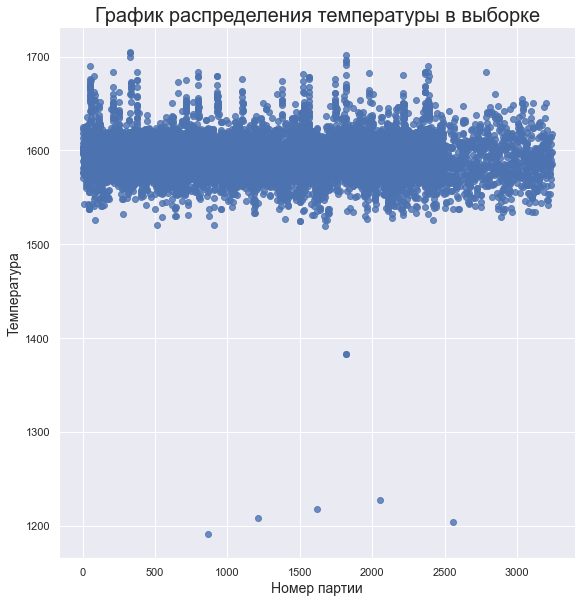

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

In [9]:
data_temp = pd.read_csv(r'C:\Users\katko\OneDrive\Desktop\data_temp.csv')
data_temp.info()
display(data_temp.head(3))

print(f'Значения "Номер партии" находятся в диапазоне: {data_temp["key"].min(), data_temp["key"].max()}',
f'Уникальных значений "Номер партии": {data_temp["key"].nunique()}', 
f'Этапы, где был всего один замер: {(data_temp["key"].value_counts() == 1).sum()}', sep='\n')


sns.lmplot(x='key', y='Температура', data=data_temp, height=8, fit_reg = False)
plt.title('График распределения температуры в выборке', fontsize=20)
plt.ylabel('Температура', fontsize=14)
plt.xlabel('Номер партии', fontsize=14)
plt.show()

display(data_temp['Температура'].describe())

По таблице `data_temp`:
- уникальных значений столбца `key` больше, чем в таблице `data_arc`,
- типы данных не соответствуют,
- имеется 2 этапа, где был всего 1 замер, надо будет удалить их в пердобработке,
- имеются сильные выбросы, их видно на `График распределения температуры в выборке`, но они почти не повлияли на значение среднего, и оно отличается от медианы менее, чем на 1 градус.
- можно будет избавиться от всех значений, выходящих за диапазон стандартного отклонения.

### Данные о проволочных материалах (объём)

In [10]:
data_wire = pd.read_csv(r'C:\Users\katko\OneDrive\Desktop\data_wire.csv')
data_wire.info()
display(data_wire.head(3))

print(f'Индексы строк, где все значения NaN: {data_wire[data_wire.isnull().all(1)].index}',
f'Значения "Номер партии" находятся в диапазоне: {data_wire["key"].min(), data_wire["key"].max()}',
f'Уникальных значений "Номер партии": {data_wire["key"].nunique()}', sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Индексы строк, где все значения NaN: Int64Index([], dtype='int64')
Значения "Номер партии" находятся в диапазоне: (1, 3241)
Уникальных значений "Номер партии": 3081


В таблице `data_wire`:
- типы данных соответствуют, 
- NaN нужно заменить 0, т.к. это означает, что проволока не подавалась,
- здесь наименьшее количество уникальных значений ключей - либо данные утеряны, либо для получения требуемого состава не потребовалось использование проволоки.

### Данные о проволочных материалах (время)

In [11]:
data_wire_time = pd.read_csv(r'C:\Users\katko\OneDrive\Desktop\data_wire_time.csv')
data_wire_time.info()
display(data_wire_time.head(3))

print(f'Индексы строк, где все значения NaN: {data_wire_time[data_wire_time.isnull().all(1)].index}',
f'Значения "Номер партии" находятся в диапазоне: {data_wire_time["key"].min(), data_wire_time["key"].max()}',
f'Уникальных значений "Номер партии": {data_wire_time["key"].nunique()}', sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Индексы строк, где все значения NaN: Int64Index([], dtype='int64')
Значения "Номер партии" находятся в диапазоне: (1, 3241)
Уникальных значений "Номер партии": 3081


В таблице `data_wire_time` всё по аналогии с предыдущей таблицей, но типы данных не соответствуют.

### Вывод

Я просмотрел все таблицы и обнаружил:
- многие типы данных не соответствуют,
- большое число пропусков, которые необходимо заполнить 0,
- построил графики распределения для четырёх наиболее важных признаков - активная и реактивная мощности и начальная, финальная температуры (их еще предстоит найти в этапе предобработки), нужно будет избавиться от выбросов,
- также предстоит переименовать столбцы, у которых название на русском,
- во всех таблицах различается количество партий.


### План действий:

1. Предобработка данных - избавиться от пропусков и аномалий, изменить  типы данных, объединить таблицы, оставить только те этапы, где есть начальный и конечный замеры температуры.
2. В полученной таблице проверить наличие этапов, где время последнего измерения температуры раньше, чем время добавления примесей и/или продувки газом и при наличии таковых - избавиться от них.
3. Обучить регрессионные модели на тренировочных данных, перебрать параметры гридсёрчем.
4. Проверить модели на тестовой выборке.

### Предобработка данных

### Данные об электродах

In [12]:
data_arc.columns = ['key', 'first_time', 'final_time', 'active_power', 'reactive_power'] # переименовываю столбцы

data_arc[['first_time','final_time']] = data_arc[['first_time', 'final_time']].apply(pd.to_datetime) # меняю тип данных

data_arc = data_arc[
    (data_arc['active_power'] <= 2.242245) & (data_arc['active_power'] >= 0) & 
    (data_arc['reactive_power'] <= 1.676603) & (data_arc['reactive_power'] >= 0)] # чищу от выбросов

data_arc['heating_time'] = (data_arc['final_time'] - data_arc['first_time']).dt.total_seconds().astype('int64') # нахожу время нагрева, перевожу в секунды

data_arc_sum = data_arc.pivot_table(
    values=['final_time', 'active_power', 'reactive_power', 'heating_time'], 
    index='key', 
    aggfunc={'final_time' : np.max, 'active_power' : np.sum, 'reactive_power' : np.sum, 'heating_time' : np.sum}) # группирую значения

data_arc_sum['full_power'] = (data_arc_sum['active_power']**2 + data_arc_sum['reactive_power']**2)**0.5 # нахожу полную мощность

data_arc_sum = data_arc_sum.drop(['active_power', 'reactive_power'], axis=1) # избавляюсь от лишних столбцов
data_arc_sum.head(3)

,final_time,heating_time,full_power
key,,,
1,2019-05-03 11:28:37,1098,5.824889
2,2019-05-03 11:53:18,811,3.648398
3,2019-05-03 12:32:19,655,2.989502


### Данные о подаче сыпучих материалов (объём)

In [13]:
data_bulk = data_bulk.fillna(0) # заполняю пропуски
data_bulk = data_bulk.set_index('key') # назначаю столбец key в качестве индексов
data_bulk.columns = [f'bulk_{i}' for i in range(1,16)] # меняю названия столбцов

data_bulk.head(3)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0


### Данные о продувке сплава газом

In [14]:
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas_1']

### Результаты измерения температуры

In [15]:
data_temp = data_temp.dropna(axis=0) # удаляю строки с пропусками
data_temp = data_temp.set_index('key') # назначаю столбец key в качестве индексов
data_temp.columns = ['measurement_time', 'temperature'] # переименовываю столбцы
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time']) # изменяю тип данных
data_temp = data_temp[(data_temp['temperature'] < 1661) & (data_temp['temperature'] > 1521)] # избавляюсь от выбросов

for key in list(data_temp.index.unique()):
    if ((data_temp[data_temp.index == key]['measurement_time'].max() < 
        data_arc_sum[data_arc_sum.index == key]['final_time'].max()) or
        (data_temp[data_temp.index == key]['measurement_time'].max() == 
        data_temp[data_temp.index == key]['measurement_time'].min())):

        data_temp = data_temp.drop(index=key) # цикл отбрасывает партии, где последнее время замера меньше последнего времени нагрева и где всего 1 измерение температуры

data_temp_max = data_temp[data_temp.groupby(data_temp.index)['measurement_time'].transform(max) == data_temp['measurement_time']] # создаю таблицу с последним временем замера
data_temp_min = data_temp[data_temp.groupby(data_temp.index)['measurement_time'].transform(min) == data_temp['measurement_time']] # создаю таблицу с первым временем замера

data_temp_max_min = data_temp_max.merge(data_temp_min, left_index=True, right_index=True) # объединяю таблицы
data_temp_max_min = data_temp_max_min.drop(['measurement_time_x', 'measurement_time_y'], axis=1) # удаляю ненужные столбцы
data_temp_max_min.columns = ['temp_final', 'temp_start'] # переименовываю столбцы

data_temp_max_min.head(3)

,temp_final,temp_start
key,,
1,1613.0,1571.0
2,1602.0,1581.0
3,1599.0,1596.0


### Данные о проволочных материалах (объём)

In [16]:
data_wire = data_wire.set_index('key') # назначаю столбец key в качестве индексов
data_wire.columns = [f'wire_{i}' for i in range(1,10)] # меняю названия столбцов
data_wire = data_wire.dropna(how='all')
data_wire = data_wire.fillna(0) # заполняю пропуски

data_wire.head(3)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь нужно объединить все таблицы в одну

In [17]:
data_total = pd.concat([data_arc_sum, data_temp_max_min, data_bulk, data_wire, data_gas], axis=1, sort=False) # объединяю таблицы
data_total = data_total.dropna(subset=['full_power', 'temp_final']) # удаляю строки с пропусками из наиболее важных признаков
data_total = data_total.fillna(0) # заполняю остальные пропуски
data_total =data_total.drop(['final_time', 'wire_5'], axis=1) # удаляю столбцы

data_total.head(3)

,heating_time,full_power,temp_final,temp_start,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas_1
key,,,,,,,,,,,,,,,,,,,,,
1,1098.0,5.824889,1613.0,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,811.0,3.648398,1602.0,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,655.0,2.989502,1599.0,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793


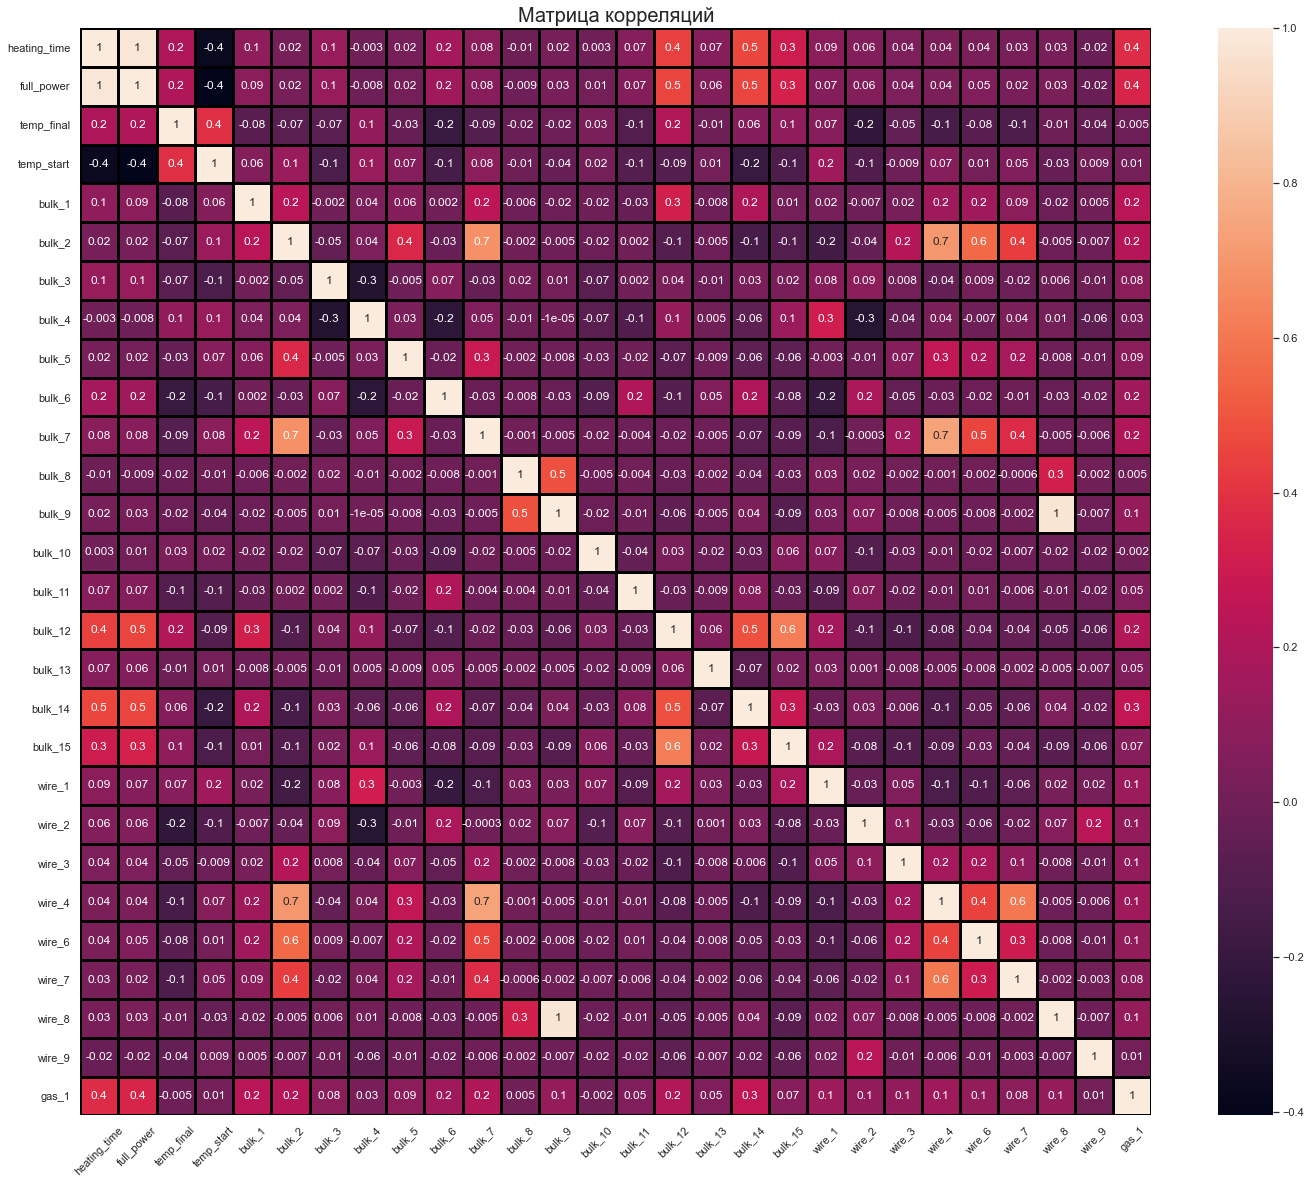

In [18]:
plt.figure(figsize=(24,20))
plt.title('Матрица корреляций', fontsize=20)
sns.heatmap(data_total.corr(), annot=True, fmt='.1g', linewidths=3, linecolor='black')
plt.xticks(rotation=45)
plt.show()

По матрице корреляций видна мультиколлинеарность между full_power и heating_time, bulk_9, wire_8, удалю heating_time и bulk_9

In [19]:
data_total = data_total.drop(['heating_time', 'bulk_9'], axis=1)

### Обучение регрессионных моделей

In [20]:
features = data_total.drop('temp_final', axis=1)
target = data_total['temp_final']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

### Линейная регрессия

In [21]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression()

### Дерево решений

In [22]:
gridParams = {'max_depth' : range(7, 9)}

model_tree = DecisionTreeRegressor(random_state=12345)
grid = GridSearchCV(model_tree, gridParams, cv=10, scoring='neg_mean_absolute_error')
grid.fit(features_train, target_train)
print(grid.best_params_)

{'max_depth': 7}


### Случайный лес

In [23]:
gridParams = {'max_depth' : range(14, 16),
              'n_estimators' : range(259, 261)}

model_forest = RandomForestRegressor(random_state=12345)
grid = GridSearchCV(model_forest, gridParams, cv=10, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
print(grid.best_params_)

{'max_depth': 15, 'n_estimators': 259}


### Катбуст

In [24]:
model_CatBoost = CatBoostRegressor(loss_function='MAE', random_seed=12345, logging_level='Silent')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [9, 11],
        'iterations' : [1, 200],
        'l2_leaf_reg': [1, 100]}

grid_search_result = model_CatBoost.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train, verbose=False)

print(grid_search_result['params'])

{'depth': 9, 'l2_leaf_reg': 100, 'iterations': 200, 'learning_rate': 0.03}


### ЛГБМ

In [25]:
gridParams = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth' : [1, 100],
    'num_leaves' : [2, 98],
    'n_estimators' : [1, 100]
    }

model_lgbm = lgb.LGBMRegressor(metric='rmse',random_state=12345)
grid = GridSearchCV(model_lgbm, gridParams, cv=2)
grid.fit(features_train, target_train)
print(grid.best_params_)

{'learning_rate': 0.1, 'max_depth': 100, 'n_estimators': 100, 'num_leaves': 98}


### Проверка моделей на тестовой выборке

### Линейная регрессия

In [26]:
predictions_test = model_lr.predict(features_test)
result = mean_absolute_error(target_test, predictions_test)
print('Значение MAE: ', result)

Значение MAE:  7.224657628898707


### Дерево решений

In [27]:
model_tree = DecisionTreeRegressor(max_depth=7, random_state=12345)
model_tree.fit(features_train, target_train)
predictions_test = model_tree.predict(features_test)
result = mean_absolute_error(target_test, predictions_test)
print('Значение MAE: ', result)

Значение MAE:  7.506777524591617


### Случайный лес

In [28]:
model_forest = RandomForestRegressor(max_depth=15, n_estimators=260, random_state=12345)
model_forest.fit(features_train, target_train)
predictions_test = model_forest.predict(features_test)
result = mean_absolute_error(target_test, predictions_test)
print('Значение MAE: ', result)

Значение MAE:  6.45537022798227


### Катбуст

In [29]:
model_CatBoost = CatBoostRegressor(loss_function='RMSE', random_seed=12345, learning_rate=0.03, depth=9, iterations=200, l2_leaf_reg=100)
model_CatBoost.fit(features_train, target_train, verbose=100)
predict_test = model_CatBoost.predict(features_test)
print('Значение MAE: ',mean_absolute_error(target_test, predict_test))

0:	learn: 13.5440928	total: 23.5ms	remaining: 4.68s
100:	learn: 10.6395487	total: 598ms	remaining: 586ms
199:	learn: 9.5778972	total: 1.16s	remaining: 0us
Значение MAE:  7.258452519627263


### ЛГБМ

In [30]:
model_lgbm = lgb.LGBMRegressor(random_state=12345,max_depth=100, num_leaves=98, n_estimators=100, learning_rate=0.1)
model_lgbm.fit(features_train, target_train)
predict_test = model_lgbm.predict(features_test)
print('Значение MAE: ',mean_absolute_error(target_test, predict_test))

Значение MAE:  6.805518067089219


### График значимости признаков для модели случайного леса

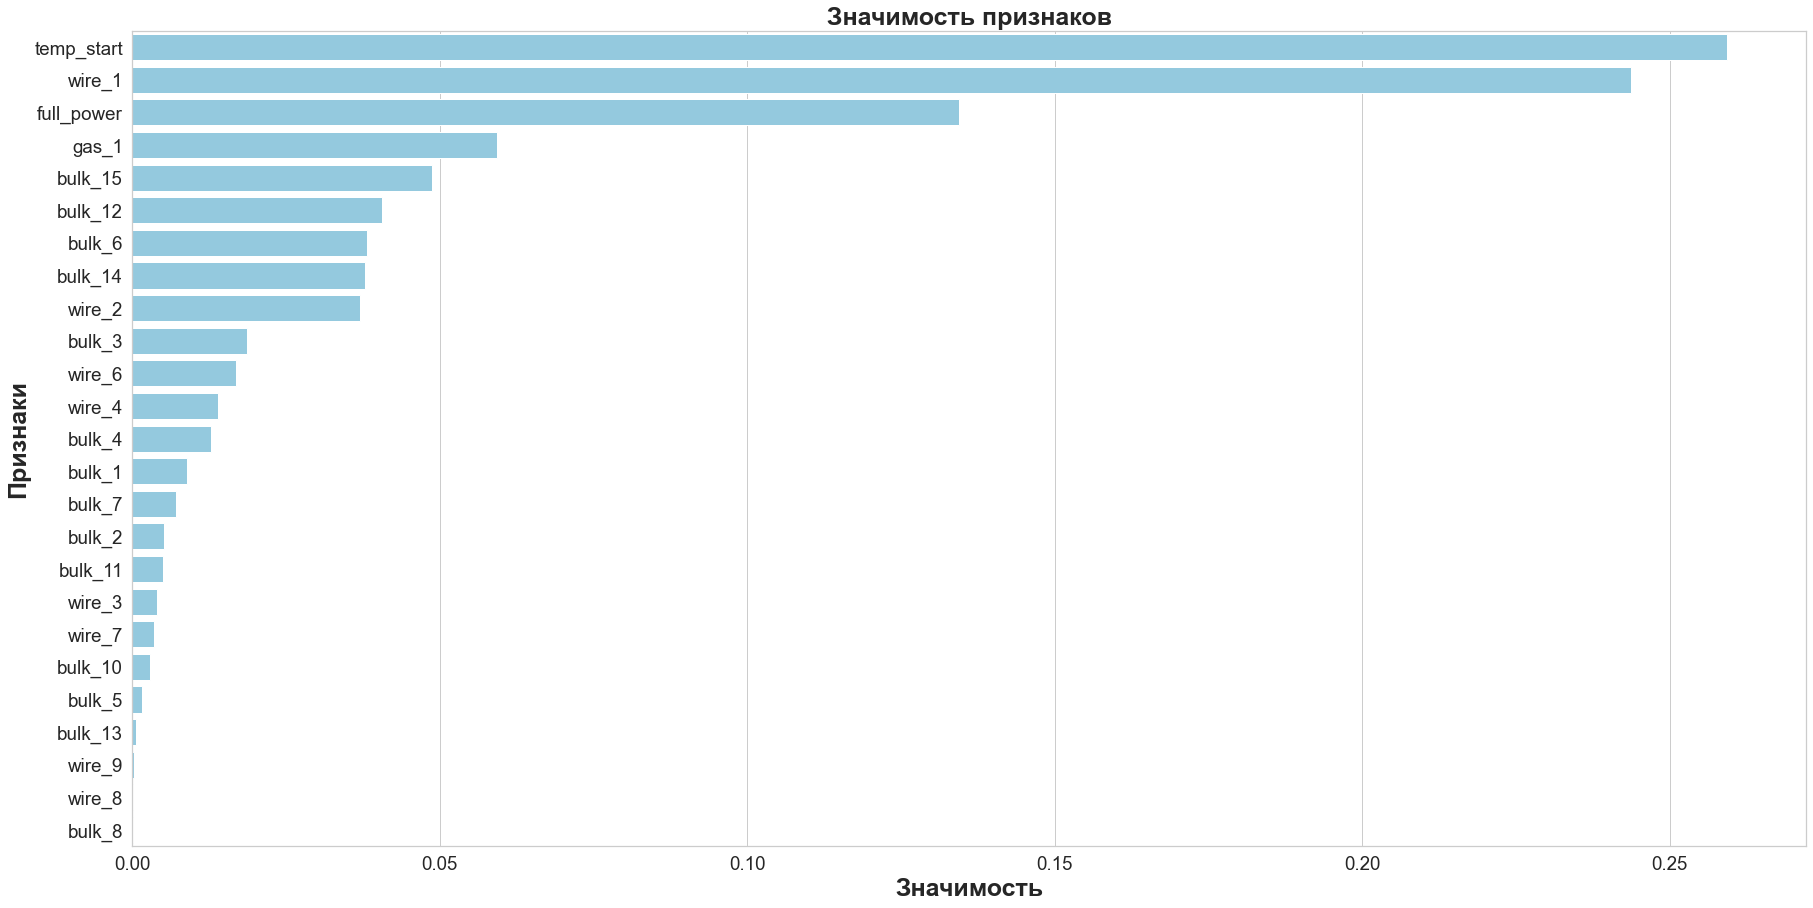

In [31]:
feats = {}
for feature, importance in zip(features_train.columns, model_forest.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Значимость', fontsize=25, weight = 'bold')
plt.ylabel('Признаки', fontsize=25, weight = 'bold')
plt.title('Значимость признаков', fontsize=25, weight = 'bold')
plt.show()

In [33]:
columns = ['Модель','MAE']
data_model = [['LinearRegression', 7.22],
             ['DecisionTreeRegressor', 7.50],
             ['RandomForestRegressor', 6.45],
             ['CatBoostRegressor', 7.25],
             ['LGBMRegressor', 6.80]]

display(pd.DataFrame(data=data_model, columns=columns))

,Модель,MAE
0,LinearRegression,7.22
1,DecisionTreeRegressor,7.50
2,RandomForestRegressor,6.45
3,CatBoostRegressor,7.25
4,LGBMRegressor,6.80


### Вывод

1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?
- В предобработке я изменил типы данных, избавился от пропусков, объединил таблицы, оставил только те этапы, где есть начальный и конечный замеры температуры, избавился от аномалий.
- В полученной таблице я не стал проверять наличие этапов, где время последнего измерения температуры раньше, чем время добавления примесей и/или продувки газом и при наличии таковых - избавляться от них, так как по таблице значимости видно, что добавки имеют малую значимость, и даже, если такие строки есть, они не окажут сильного влияния, но сделал эти действия с таблицей нагрева, убрав все этапы, где последний замер по времени раньше, чем нагрев.
- Обучить регрессионные модели на тренировочных данных, перебрать параметры гридсёрчем - этот пункт выполнен.
Проверить модели на тестовой выборке - этот пункт выполнен.
2. Какие трудности возникли и как вы их преодолели? 
- Трудности возникли с тем, что в первом варианте работы я удалил очень много значений (всё, что за пределами стандартного отклонения) и все модели дали очень высокие показатели МАЕ от 5.2 до 5.7, но ревьюер подсказал, что так делать не стоит и я отбросил в конечном варианте все значения за пределами q_3 + 3*irq, что негативно сказалось на качестве предсказаний и тут уже перебор параметров не сильно помог и лучшее значение МАЕ - 6.45. Тоесть вся сложность в том, что качество зависит напрямую от того, сколько данных я откину.
3. Какие ключевые шаги в решении задачи выделили?
- Исследование данных
- Предобработка 
- Обучение моделей, перебор параметров
- Тестирование моделей
4. Какая ваша итоговая модель и какое у неё качество?
- RandomForestRegressor - 6.45